## Libs no Projeto

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

# Exploração dos dados

## Leitura e Verificação dos dados

In [3]:
path_csv = '/content/drive/MyDrive/Colab Notebooks/Manipulae - Case/dados_preco.csv'

In [4]:
df = pd.read_csv(path_csv)
df

,descricao,criado,qtdInsumos,calculado,correto
0,30 CAP | BUPROPIONA CLORIDRATO 150MG,2020-08-05 23:19:09,1,47.5297,39.9
1,60 CAP | FINASTERIDA 1:10 1MG,2020-08-05 22:51:09,1,46.9620,43.6
2,60 CAP | NAC 250MG; SILIMARINA 150MG; SAME ...,2020-08-05 22:51:09,3,105.1390,111.4
3,60 CAP | ANASTROZOL 1:10 0.300MG,2020-08-05 22:51:09,1,49.0314,43.6
4,120 CAP | DUTASTERIDA 0.250MG; TADALAFIL 10MG,2020-08-05 22:49:09,2,161.8272,146.0
...,...,...,...,...,...
7116,45 CAP | SERTRALINA CLORIDRATO 40MG; SLENDEST...,2020-07-09 17:33:11,12,188.5325,181.8
7117,120 CAP | GREENSELECT 120MG,2020-07-09 17:24:09,1,377.6529,346.6
7118,60 CAP | MAGNESIO QUELADO 30% 220MG; SELENIO ...,2020-07-09 17:23:10,11,166.2868,157.2
7119,30 CAP | VALERIANA 50MG; PASSIFLORA 500MG; C...,2020-07-09 17:22:09,3,60.1646,68.1


In [5]:
df.isna().sum()

descricao     0
criado        0
qtdInsumos    0
calculado     0
correto       0
dtype: int64

não temos nenhum dado faltante em todo o dataframe.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7121 entries, 0 to 7120
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   descricao   7121 non-null   object 
 1   criado      7121 non-null   object 
 2   qtdInsumos  7121 non-null   int64  
 3   calculado   7121 non-null   float64
 4   correto     7121 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 278.3+ KB


duas colunas tratadas como string e três com tipo numérico

#### Exploração de algumas informações

In [7]:
df.duplicated().sum()

0

nenhum informação duplicada.

In [8]:
df.describe()

,qtdInsumos,calculado,correto
count,7121.000000,7121.000000,7121.000000
mean,3.281842,137.089552,135.891798
std,3.194301,191.266516,189.806974
min,1.000000,30.000100,33.000000
25%,1.000000,49.786100,49.500000
50%,2.000000,87.350300,83.100000
75%,4.000000,165.167000,161.200000
max,26.000000,10364.992500,10356.000000


In [9]:
df.qtdInsumos.value_counts()

1     2843
2     1163
3      931
4      538
5      395
6      296
7      235
8      189
9      122
10      93
11      75
12      57
13      46
14      43
15      34
16      25
17      14
18       8
21       3
25       3
19       3
26       3
23       2
Name: qtdInsumos, dtype: int64

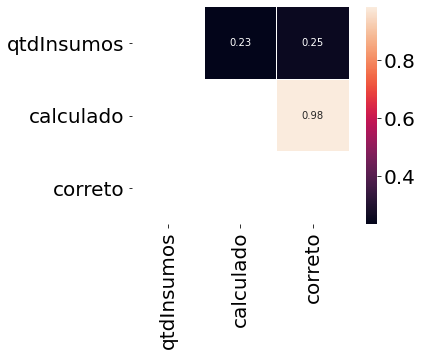

In [10]:
matrix_corr = df.corr()
mask = np.tril(np.ones_like(matrix_corr, dtype=np.bool))
sns.heatmap(matrix_corr, fmt='.2f', annot=True, mask=mask, square=True, linewidths=.2);

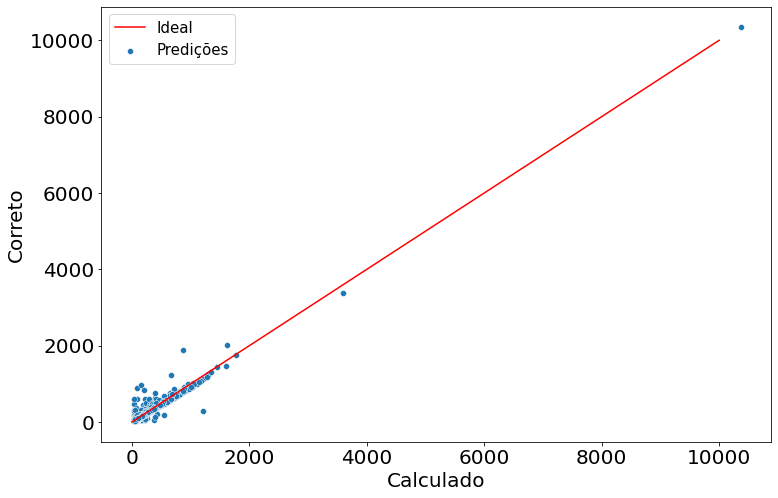

In [11]:
plt.figure(figsize=(12,8))
sns_t = sns.scatterplot(x=df.calculado, y=df.correto, label='Predições')
plt.plot((0, 10000), (0, 10000), color='red', label='Ideal')

sns_t.set_ylabel('Correto', size=20)
sns_t.set_xlabel('Calculado', size=20)
plt.legend(prop={'size':15});

## Manipulação e Modelagem de Colunas

### Separação volume e componentes

In [12]:
qtd_cap = list()
components = list()

for info in df.descricao:
  list_exp = info.split('|')
  
  # qtd_cap == list_exp[0]
  list_num_cap = list_exp[0].split(' ')
  num_cap = int(list_num_cap[0])
  qtd_cap.append(num_cap)

  # components == list_exp[1]
  components.append(list_exp[1])

In [13]:
df['num_cap'] = qtd_cap
df['components'] = components

In [14]:
df.head(5)

,descricao,criado,qtdInsumos,calculado,correto,num_cap,components
0,30 CAP | BUPROPIONA CLORIDRATO 150MG,2020-08-05 23:19:09,1,47.5297,39.9,30,BUPROPIONA CLORIDRATO 150MG
1,60 CAP | FINASTERIDA 1:10 1MG,2020-08-05 22:51:09,1,46.9620,43.6,60,FINASTERIDA 1:10 1MG
2,60 CAP | NAC 250MG; SILIMARINA 150MG; SAME ...,2020-08-05 22:51:09,3,105.1390,111.4,60,NAC 250MG; SILIMARINA 150MG; SAME 50MG
3,60 CAP | ANASTROZOL 1:10 0.300MG,2020-08-05 22:51:09,1,49.0314,43.6,60,ANASTROZOL 1:10 0.300MG
4,120 CAP | DUTASTERIDA 0.250MG; TADALAFIL 10MG,2020-08-05 22:49:09,2,161.8272,146.0,120,DUTASTERIDA 0.250MG; TADALAFIL 10MG


### Ajustes na Data

In [15]:
data_full = list()

for data in df.criado:
  data_c = data[:10]
  data_full.append(data_c)

In [16]:
df['data'] = data_full

In [17]:
df.head(3)

,descricao,criado,qtdInsumos,calculado,correto,num_cap,components,data
0,30 CAP | BUPROPIONA CLORIDRATO 150MG,2020-08-05 23:19:09,1,47.5297,39.9,30,BUPROPIONA CLORIDRATO 150MG,2020-08-05
1,60 CAP | FINASTERIDA 1:10 1MG,2020-08-05 22:51:09,1,46.9620,43.6,60,FINASTERIDA 1:10 1MG,2020-08-05
2,60 CAP | NAC 250MG; SILIMARINA 150MG; SAME ...,2020-08-05 22:51:09,3,105.1390,111.4,60,NAC 250MG; SILIMARINA 150MG; SAME 50MG,2020-08-05


### Criação de variáveis

In [18]:
dummies = df[['components', 'num_cap', 'qtdInsumos', 'calculado']]
df_dummies = pd.get_dummies(dummies)

In [19]:
label_encoder = LabelEncoder()
label_encoder.fit(df.components)

desc_encode = label_encoder.transform(df.components)
df['encoded_desc'] = desc_encode

In [20]:
len(df['encoded_desc'].unique())

5736

In [21]:
df['calculado2'] = df['calculado'] ** 2

In [22]:
df['calculado3'] = df['calculado'] ** 3

In [23]:
df['calculado4'] = df['calculado'] ** (1/2)

In [24]:
df['var_x'] = df['num_cap'] * df['qtdInsumos'];

In [25]:
df['var_x2'] = df['num_cap'] * df['calculado']

In [26]:
df['var_x3'] = df['encoded_desc'] * df['num_cap']

In [27]:
df['var_x4'] = df['calculado'] * df['var_x'];

In [28]:
df['var_x5'] = df['calculado'] * df['var_x4'];

In [29]:
df.head(2)

,descricao,criado,qtdInsumos,calculado,correto,num_cap,components,data,encoded_desc,calculado2,calculado3,calculado4,var_x,var_x2,var_x3,var_x4,var_x5
0,30 CAP | BUPROPIONA CLORIDRATO 150MG,2020-08-05 23:19:09,1,47.5297,39.9,30,BUPROPIONA CLORIDRATO 150MG,2020-08-05,829,2259.072382,107373.032599,6.894179,30,1425.891,24870,1425.891,67772.171463
1,60 CAP | FINASTERIDA 1:10 1MG,2020-08-05 22:51:09,1,46.9620,43.6,60,FINASTERIDA 1:10 1MG,2020-08-05,1957,2205.429444,103571.377549,6.852883,60,2817.720,117420,2817.720,132325.766640


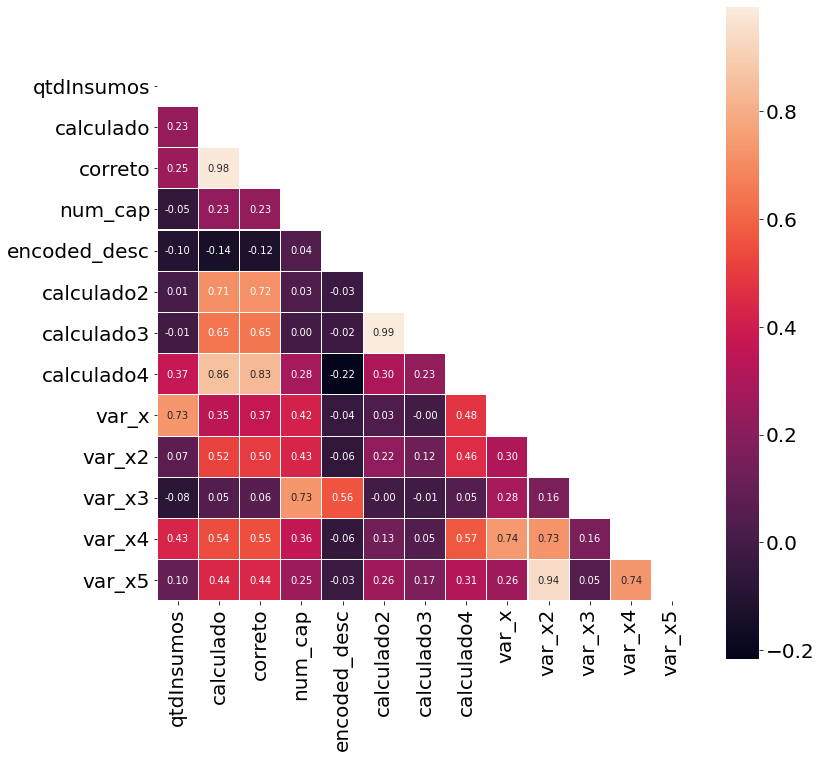

In [30]:
matrix_corr = df.corr()
mask = np.triu(np.ones_like(matrix_corr, dtype=np.bool))

plt.figure(figsize=(12,12))
sns.heatmap(matrix_corr, fmt='.2f', annot=True, mask=mask, square=True, linewidths=.2);

# Machine Learning

## Predição dos dados

In [31]:
df = df.query('correto < 1200')
index_outliers = df.query('correto > 1200').index
index_outliers_t = [i for k,i in enumerate(index_outliers) if (k == 0 or k == 6)]
index_outliers_v = index_outliers[8:10]

In [32]:
# x = df_dummies
x = df[['encoded_desc', 'num_cap', 'qtdInsumos', 'calculado', 'calculado2', 'calculado3', 'calculado4', 'var_x', 'var_x2', 'var_x5']]
y = df.correto

In [33]:
# Treinamento
x_train = x[:5121].drop(index=index_outliers_t)
y_train = y[:5121].drop(index=index_outliers_t)

# Validação
x_val = x[5121:].drop(index=index_outliers_v)
y_val = y[5121:].drop(index=index_outliers_v)

### Construção do Modelo de Predição

### Funções auxiliares

In [34]:
def show_metrics(results):
    r2 = results["test_r2"].mean()
    mse = results["test_neg_mean_squared_error"].mean()
    mae = results["test_neg_mean_absolute_error"].mean()
    rmse = results["test_neg_root_mean_squared_error"].mean()
    print("----------------------")
    print(f"R2_Mean: {r2*100:.2f}%")
    print(f"MSE_Mean: {-mse}")
    print(f"MAE_Mean: {-mae}")
    print(f"RMSE_Mean: {-rmse}")

In [35]:
def qual_test(df, model, max, min=0):
  df_100 = df.query(f'correto < {max} and correto > {min}')

  x_100 = df_100[['encoded_desc', 'num_cap', 'qtdInsumos', 'calculado', 'calculado2', 'calculado3', 'calculado4', 'var_x', 'var_x2', 'var_x5']]
  y_100 = df_100.correto

  x_100 = x_100[-500:]
  y_100 = y_100[-500:]

  pred_100 = model.predict(x_100)

  r2 = r2_score(y_100, pred_100) * 100
  mse = mean_squared_error(y_100, pred_100)
  mae = mean_absolute_error(y_100, pred_100)
  mape = np.mean(np.abs((y_100 - pred_100) / y_100)) * 100

  print(f'R2: {r2:.2f}%\nMSE: {mse:.2f}\nMAE: {mae:.2f}\nMAPE: {mape:.2f}%')

In [36]:
def plot_graph(model):
  pred_tree = (model.predict(x_val))

  fig, axes = plt.subplots(2, 2, figsize=(16, 14),constrained_layout=True)

  axes[0][0].set_ylabel('Correto', size=20)
  axes[0][0].set_xlabel('Predição', size=20)
  axes[0][0].set_title('Dados Totais', size=20)
  sns.scatterplot(x=pred_tree, y=y_val, ax=axes[0][0])
  axes[0][0].plot((0, 3500), (0, 3500), color='black')

  axes[0][1].set_ylabel('Correto', size=20)
  axes[0][1].set_xlabel('Predição', size=20)
  axes[0][1].set_title('Dados até R$ 1.200', size=20)
  axes[0][1].set_xlim(0, 1200)
  axes[0][1].set_ylim(0, 1200)
  sns.scatterplot(x=pred_tree, y=y_val , ax=axes[0][1], color='red')
  axes[0][1].plot((0, 3500), (0, 3500), color='black')

  axes[1][0].set_ylabel('Correto', size=20)
  axes[1][0].set_xlabel('Predição', size=20)
  axes[1][0].set_title('Dados até R$ 400', size=20)
  axes[1][0].set_xlim(0, 400)
  axes[1][0].set_ylim(0, 400)
  sns.scatterplot(x=pred_tree, y=y_val , ax=axes[1][0], color='green')
  axes[1][0].plot((0, 3500), (0, 3500), color='black');

  axes[1][1].set_ylabel('Correto', size=20)
  axes[1][1].set_xlabel('Predição', size=20)
  axes[1][1].set_title('Dados até R$ 100', size=20)
  axes[1][1].set_xlim(30, 100)
  axes[1][1].set_ylim(30, 100)
  sns.scatterplot(x=pred_tree, y=y_val , ax=axes[1][1], color='gray')
  axes[1][1].plot((0, 3500), (0, 3500), color='black');

## Gradient Boosting

### Definição e Parametrização do Modelo

In [37]:
model = GradientBoostingRegressor()

# Pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model)
])


# Paramêtros de Busca
# parameters = {
#     'model__criterion' : ['friedman_mse', 'mse'],
#     'model__max_depth' : [3, 4, 5],
#     'model__learning_rate' : [0.1],
#     'model__loss' : ['huber'],
#     'model__n_estimators' : [300, 400],
#     'model__warm_start' : [True]
# }

parameters = {
    'model__criterion' : ['friedman_mse', 'mse'],
    'model__max_depth' : [3, 5],
    'model__learning_rate' : [0.1],
    'model__loss' : ['huber'],
    'model__n_estimators' : [400],
    'model__warm_start' : [True]
}

#### GridSearch e Resultados

In [38]:
grid = GridSearchCV(pipe, parameters, cv=10)
grid.fit(x_train, y_train)
best_model_tree = grid.best_estimator_
df_s = pd.DataFrame(grid.cv_results_)
df_s.sort_values(by="rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__learning_rate,param_model__loss,param_model__max_depth,param_model__n_estimators,param_model__warm_start,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,7.647984,2.337362,0.009716,0.010306,friedman_mse,0.1,huber,3,400,True,"{'model__criterion': 'friedman_mse', 'model__l...",0.817196,0.968015,0.897623,0.982361,0.923583,0.947097,0.955800,0.979475,0.928485,0.904460,0.930409,0.046968,1
2,6.386622,0.139030,0.004801,0.000270,mse,0.1,huber,3,400,True,"{'model__criterion': 'mse', 'model__learning_r...",0.817111,0.966351,0.901549,0.982396,0.923137,0.944863,0.954374,0.979926,0.921436,0.904383,0.929553,0.046586,2
1,10.682274,0.300292,0.006651,0.000370,friedman_mse,0.1,huber,5,400,True,"{'model__criterion': 'friedman_mse', 'model__l...",0.819853,0.969940,0.912348,0.982063,0.918986,0.939212,0.952733,0.980157,0.924704,0.895481,0.929548,0.046050,3
3,10.867247,1.120178,0.007056,0.000961,mse,0.1,huber,5,400,True,"{'model__criterion': 'mse', 'model__learning_r...",0.821101,0.964587,0.908522,0.981779,0.916653,0.937055,0.950546,0.979631,0.938190,0.896405,0.929447,0.045281,4


### Métricas de avaliação do Modelo

In [39]:
best_model_tree.fit(x_train, y_train)
results = cross_validate(best_model_tree, 
                         x_val, 
                         y_val,
                         cv=10, 
                         scoring=('r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error'),
                         return_train_score=True)

show_metrics(results)

----------------------
R2_Mean: 95.19%
MSE_Mean: 879.5384718151572
MAE_Mean: 10.578824027246522
RMSE_Mean: 28.067018118421487


### Gráficos de Análise de Dispersão das Predições

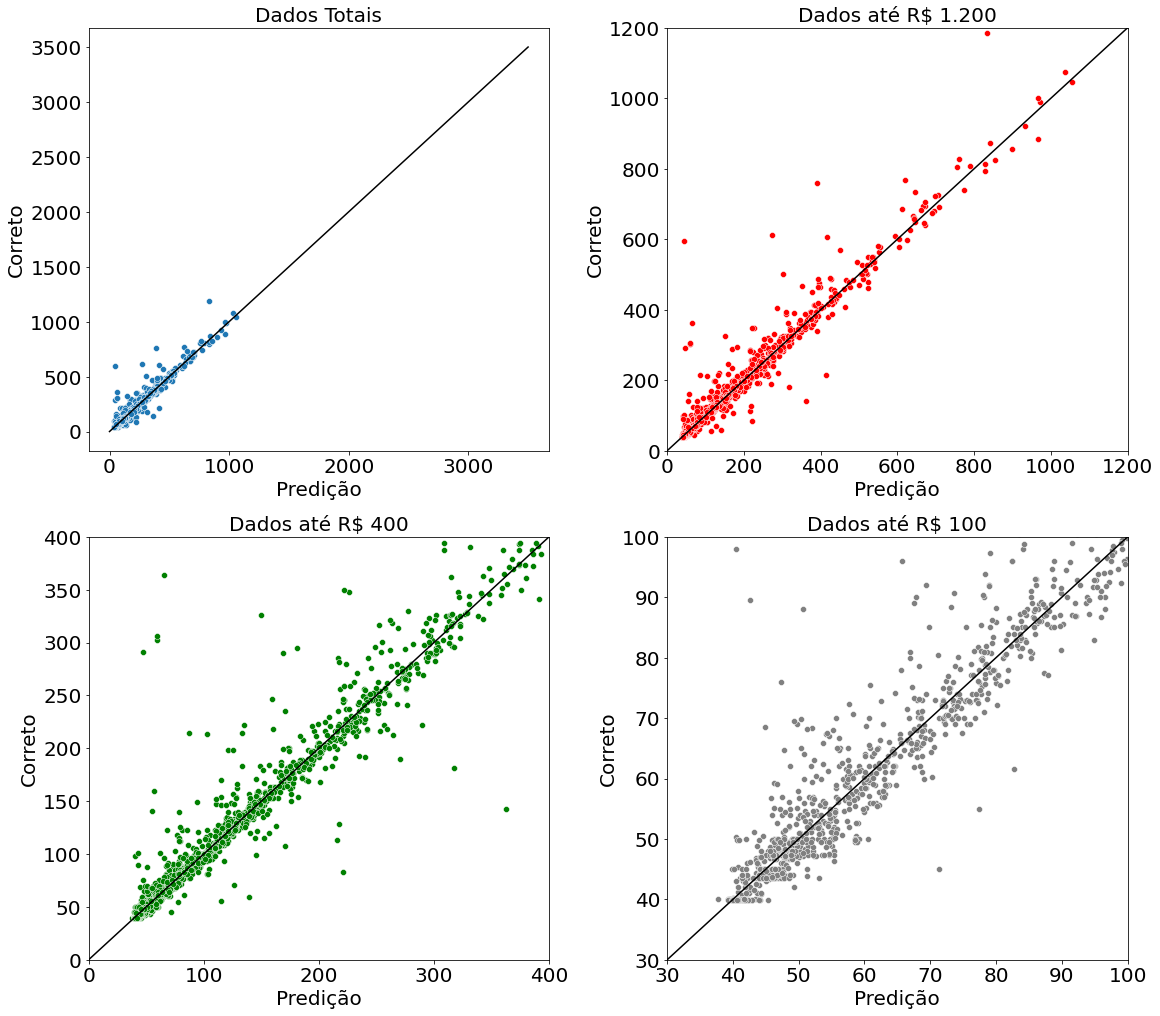

In [40]:
plot_graph(best_model_tree)

### Análise da Features mais relevantes

In [41]:
from sklearn.feature_selection import RFECV

model = GradientBoostingRegressor(loss='huber', criterion='friedman_mse', max_depth=5)

select_rfecv = RFECV(estimator=model, cv=5, step=1, scoring='r2')
select_rfecv.fit(x_train, y_train)

train_rfecv = select_rfecv.transform(x_train)

model.fit(train_rfecv, y_train)

results = cross_validate(model, 
                         x_val, 
                         y_val,
                         cv=10, 
                         scoring=('r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error'),
                         return_train_score=True)

show_metrics(results)

display(x_train.columns[select_rfecv.support_])
select_rfecv.grid_scores_

----------------------
R2_Mean: 94.79%
MSE_Mean: 959.6175658044774
MAE_Mean: 11.456937184786211
RMSE_Mean: 29.665533405009068


Index(['encoded_desc', 'num_cap', 'calculado', 'calculado2', 'calculado3',
       'calculado4', 'var_x2', 'var_x5'],
      dtype='object')

array([0.90971469, 0.90970164, 0.90968122, 0.90970135, 0.91976239,
       0.92041878, 0.92349407, 0.92506059, 0.92336996, 0.92164979])

## Cat Boost

### Grid Search e Resultados

In [42]:
!pip install catboost
import catboost

model_cat = catboost.CatBoostRegressor()

# Pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model_cat)
])


# Paramêtros de Busca
parameters = {
    'model__learning_rate': [0.1],
    'model__loss_function' : ['RMSE', 'MAE'],
    'model__max_depth' : [4, 5, 6],
    'model__n_estimators' : [200, 400],
    'model__silent' : [True]
}

grid_cat = GridSearchCV(pipe, parameters, cv=10)
grid_cat.fit(x_train, y_train)
best_model_cat = grid_cat.best_estimator_
df_s_cat = pd.DataFrame(grid_cat.cv_results_)
df_s_cat.sort_values(by="rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__loss_function,param_model__max_depth,param_model__n_estimators,param_model__silent,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
9,1.111093,0.010778,0.002782,0.000270,0.1,MAE,5,400,True,"{'model__learning_rate': 0.1, 'model__loss_fun...",0.819875,0.972433,0.970333,0.980615,0.947192,0.933248,0.955517,0.983083,0.955158,0.902774,0.942023,0.046712,1
8,0.579395,0.009293,0.002431,0.000111,0.1,MAE,5,200,True,"{'model__learning_rate': 0.1, 'model__loss_fun...",0.820537,0.970886,0.969297,0.980353,0.944663,0.931114,0.955589,0.982967,0.954898,0.902443,0.941275,0.046388,2
10,0.772660,0.029428,0.002403,0.000076,0.1,MAE,6,200,True,"{'model__learning_rate': 0.1, 'model__loss_fun...",0.820064,0.970816,0.969958,0.978589,0.947275,0.935390,0.955635,0.980478,0.956041,0.898203,0.941245,0.046548,3
11,1.484864,0.015834,0.003292,0.001682,0.1,MAE,6,400,True,"{'model__learning_rate': 0.1, 'model__loss_fun...",0.819230,0.971817,0.970075,0.977363,0.946488,0.938155,0.954518,0.979945,0.955917,0.898660,0.941217,0.046581,4
7,0.877677,0.008470,0.002680,0.000144,0.1,MAE,4,400,True,"{'model__learning_rate': 0.1, 'model__loss_fun...",0.820519,0.970860,0.970164,0.980465,0.945119,0.933496,0.955791,0.981394,0.955739,0.898169,0.941172,0.046680,5


### Métricas de Avaliação do Modelo

In [43]:
best_model_cat.fit(x_train, y_train)
results = cross_validate(best_model_cat, 
                         x_val, 
                         y_val,
                         cv=10, 
                         scoring=('r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error'),
                         return_train_score=True)

show_metrics(results)

----------------------
R2_Mean: 95.01%
MSE_Mean: 943.3943864508321
MAE_Mean: 10.990249558157284
RMSE_Mean: 29.538770600672002


### Gráficos de Análise de Dispersão da Predição

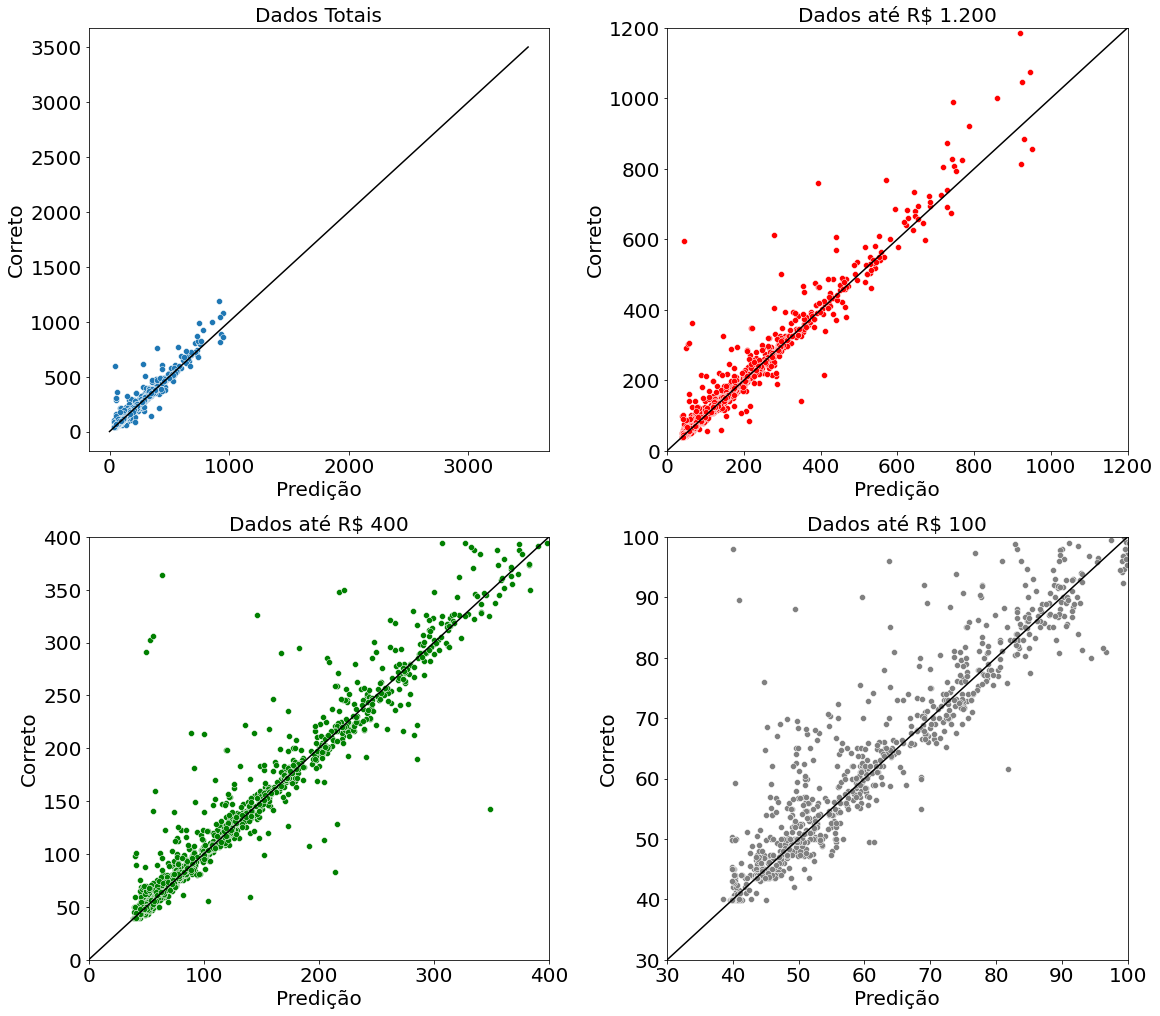

In [44]:
plot_graph(best_model_cat)

# Teste Qualitativo dos Modelos

## Avaliação dos modelos nos últimos 500 dados

### Gradient Boosting

In [45]:
qual_test(df, best_model_tree, 400, 0)

R2: 93.55%
MSE: 431.09
MAE: 7.95
MAPE: 6.38%


### Cat Boost

In [46]:
qual_test(df, best_model_cat, 400, 0)

R2: 93.78%
MSE: 415.50
MAE: 7.68
MAPE: 5.90%


## Ensemble entre os Modelos

### Métricas de Avaliação

In [47]:
estimators=[('gb', best_model_tree), ('cb', best_model_cat)]

ensemble = VotingRegressor(estimators)

ensemble.fit(x_train, y_train)

results = cross_validate(ensemble, 
                         x_val, 
                         y_val,
                         cv=10, 
                         scoring=('r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error'),
                         return_train_score=True)

show_metrics(results)

----------------------
R2_Mean: 95.27%
MSE_Mean: 879.2131612319438
MAE_Mean: 10.354304904998157
RMSE_Mean: 28.287931204388677


### Teste Qualitativo

In [48]:
qual_test(df, ensemble, 400, 0)

R2: 94.06%
MSE: 396.94
MAE: 7.51
MAPE: 5.91%


### Gráficos de Dipersão das Predições

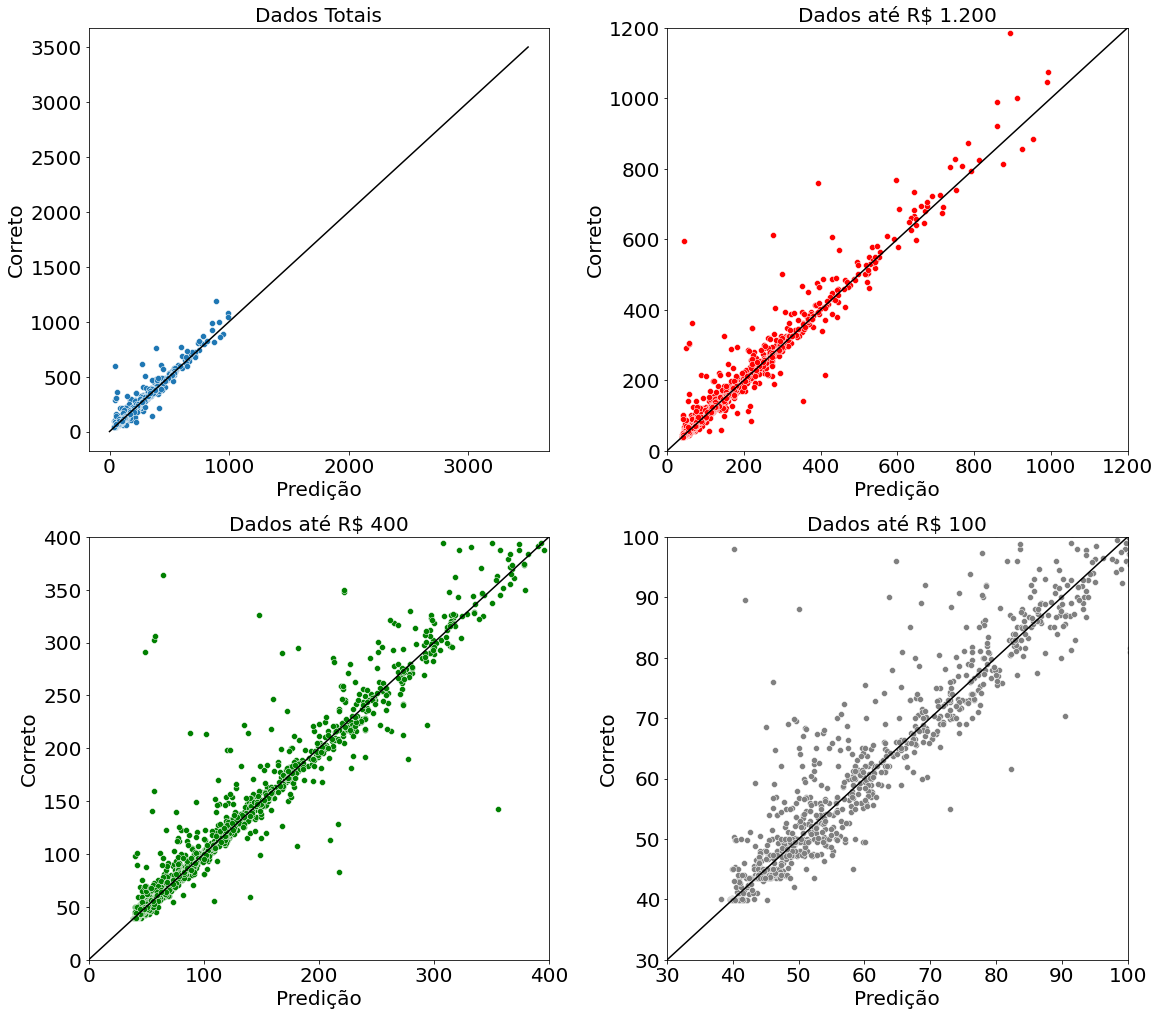

In [49]:
plot_graph(ensemble)

In [50]:
df_100 = df.query(f'correto < 400 and correto > 0')

x_100 = df_100[['encoded_desc', 'num_cap', 'qtdInsumos', 'calculado', 'calculado2', 'calculado3', 'calculado4', 'var_x', 'var_x2', 'var_x5']]
y_100 = df_100.correto

x_100 = x_100[-500:]
y_100 = y_100[-500:]

pred_ens = ensemble.predict(x_100)

df_an = pd.DataFrame({'pred':pred_ens, 'cor':y_100})
df_an['diff'] = df_an['cor'] - df_an['pred']
df_an = df_an.sort_values(by=('cor'))
df_an = df_an.reset_index(drop=True)

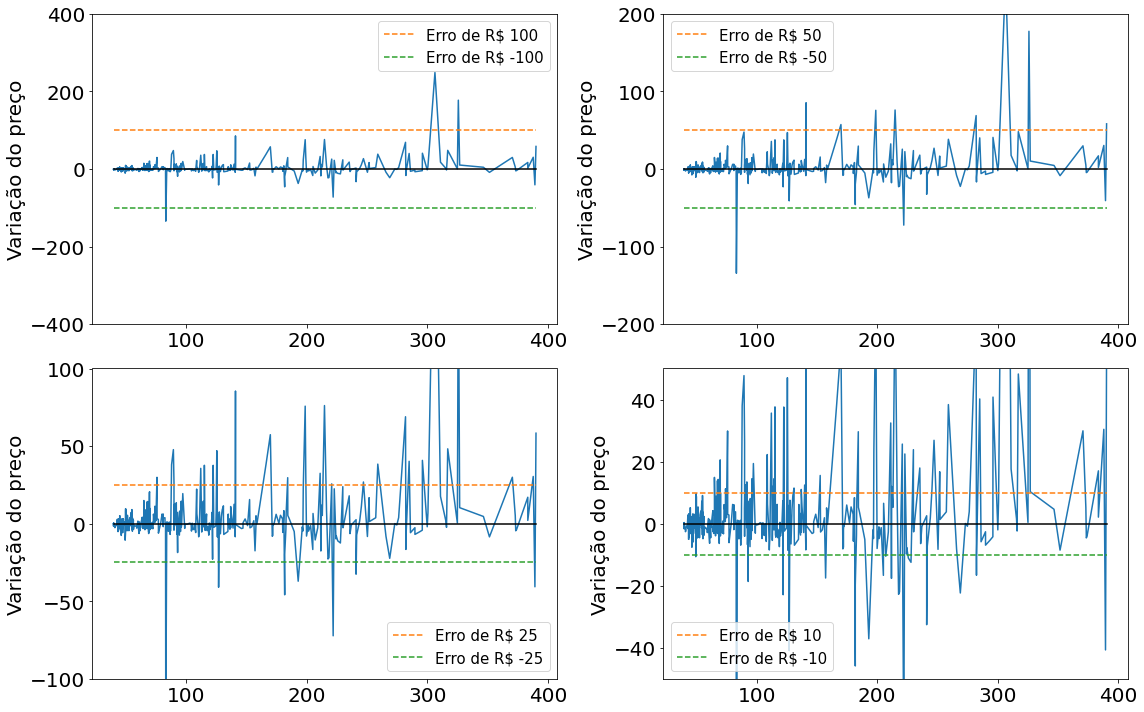

In [51]:
fig= plt.figure(figsize=(16, 10))

values = [100, 50, 25, 10]
sizes = [400, 200, 100, 50]

for i,l in enumerate(zip(values, sizes)):
  ax = fig.add_subplot(2, 2, i+1)

  ax.plot(df_an['cor'], df_an['diff'])
  ax.plot((min(df_an.cor), max(df_an.cor)), (l[0],l[0]), label=f'Erro de R$ {l[0]}', ls='--')
  ax.plot((min(df_an.cor), max(df_an.cor)), (-l[0],-l[0]), label=f'Erro de R$ {-l[0]}', ls='--')
  ax.plot((min(df_an.cor), max(df_an.cor)), (0,0), color='black')
  ax.set_ylim(-l[1], l[1])
  ax.set_ylabel('Variação do preço', size=20)
  ax.legend(prop={'size':15})
  plt.tight_layout();